In [25]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import warnings
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [10, 5]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [2]:
title_ass = pd.read_csv('./associations/title_associations.csv')
body_ass = pd.read_csv('./associations/body_associations.csv')

In [3]:
title_ass.set_index('token', inplace=True)
body_ass.set_index('token', inplace=True)

In [4]:
title_ass.head()

,pobability,tag
token,,
check,0.002395,file-upload
check,0.000653,image-processing
check,0.000435,mime-types
check,0.105916,php
check,0.001252,upload


In [5]:
body_ass.head()

,pobability,tag
token,,
anoth,0.001374,file-upload
anoth,0.001472,image-processing
anoth,0.000182,mime-types
anoth,0.067169,php
anoth,0.000876,upload


##### Creating the multilabel vetorizer for the labels

In [6]:
conn = sqlite3.connect('dataset/finalTrain.db')
train = pd.read_sql_query('SELECT * FROM train', conn)
valid = pd.read_sql_query('SELECT * FROM validation', conn)

In [23]:
tqdm.pandas()

In [29]:
# valid['body'] = valid.body.progress_apply(lambda x: re.sub('\\', '', x))
valid['body'] = valid.body.apply(lambda x: re.sub('/', '', x))
valid['body'] = valid.body.apply(lambda x: re.sub('@', '', x))
valid['body'] = valid.body.apply(lambda x: re.sub('\[', '', x))
valid['body'] = valid.body.apply(lambda x: re.sub('\]', '', x))

In [7]:
all_tags = []

In [8]:
for tag in tqdm(train.Tags):
    all_tags.extend(tag.split())

100%|██████████| 2000001/2000001 [00:01<00:00, 1078841.81it/s]


In [9]:
for tag in tqdm(valid.Tags):
    all_tags.extend(tag.split())

100%|██████████| 2206306/2206306 [00:02<00:00, 1009047.28it/s]


In [10]:
tags = pd.concat([train.Tags, valid.Tags], ignore_index=True)

In [11]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')

In [12]:
vectorizer.fit(tags)

CountVectorizer(analyzer='word', binary='true', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x7f207eeb1378>, vocabulary=None)

##### Creating the the predict function from the association tables (title & body)

In [13]:
def predict_tags(title, table):
    title = title.split()
    tags = set()
    for word in title:
        try:
            tags.update(np.unique(table.loc[word].tag[0:5]))
        except:
            pass
    return sorted(tags)

##### Fitting for the hypter-param for the tittle associations

In [ ]:
ITERS = 10
FOLDSIZE = 100
f1_scores = {}
for threshold in [0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25]:
    f1s = []
    table = title_ass[title_ass.pobability >= threshold]
    for itr in tqdm(range(ITERS)):
        ## Sample the validation data of FOLDSIZE
        sample = valid.sample(FOLDSIZE)
        true = []
        pred = []
        for title, tag in tqdm(zip(sample.Title, sample.Tags)):
            pred.append(predict_tags(title, table))
            true.append(sorted(tag.split()))
        true_str = []
        pred_str = []
        for t, p in zip(true, pred):
            true_str.append(' '.join(t))
            pred_str.append(' '.join(p))
        T = vectorizer.transform(true_str)
        P = vectorizer.transform(pred_str)
        f1 = f1_score(T, P, average='micro')
        f1s.append(f1)
    f1_scores[str(round(threshold, 2))] = np.mean(f1s)
#     print(f'Done for {threshold}')

In [272]:
scores_titles = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['f1_score'])

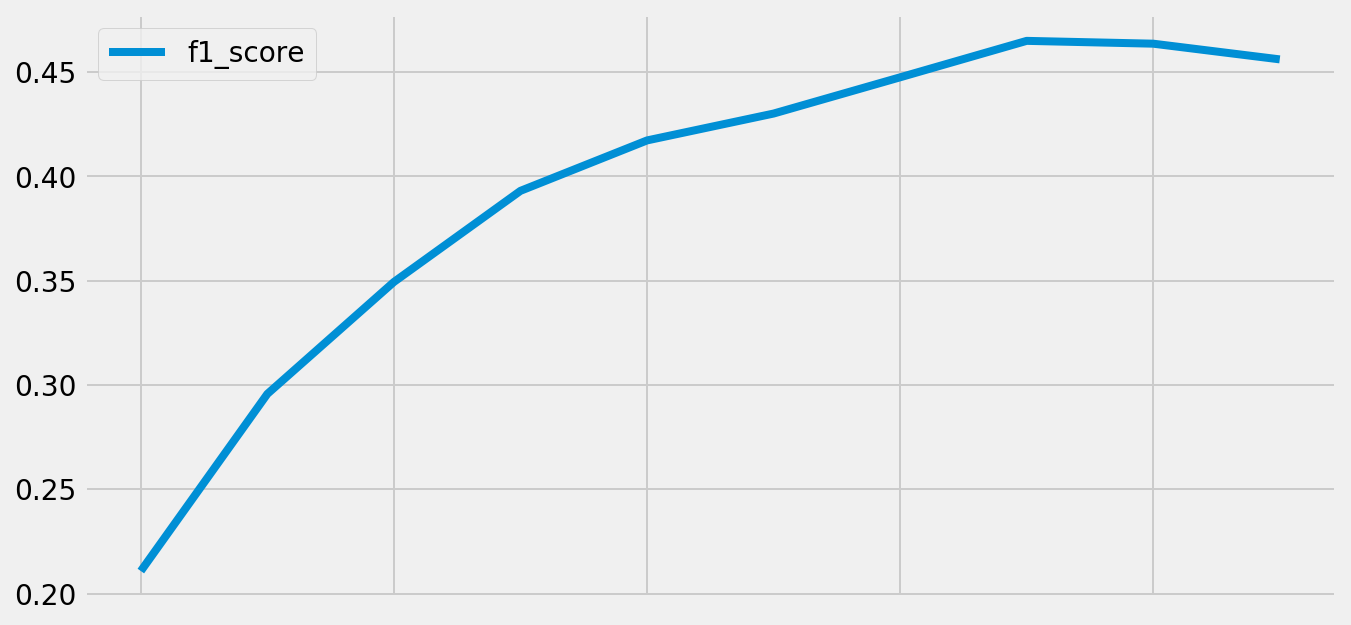

In [281]:
scores_titles.plot.line();

##### Fitting for the hyperparamerter for the body associations

In [ ]:
ITERS = 10
FOLDSIZE = 100
f1_scores = {}
for threshold in [0.5, 0.4, 0.3, 0.35]:
    f1s = []
    table = body_ass[body_ass.pobability >= threshold]
    table.set_index('token', inplace=True)
    for itr in tqdm(range(ITERS)):
        ## Sample the validation data of FOLDSIZE
        sample = valid.sample(FOLDSIZE)
        true = []
        pred = []
        for body, tag in tqdm(zip(sample.body, sample.Tags)):
            pred.append(predict_tags(body, table))
            true.append(sorted(tag.split()))
        true_str = []
        pred_str = []
        for t, p in zip(true, pred):
            true_str.append(' '.join(t))
            pred_str.append(' '.join(p))
        T = vectorizer.transform(true_str)
        P = vectorizer.transform(pred_str)
        f1 = f1_score(T, P, average='micro')
        f1s.append(f1)
    f1_scores[str(round(threshold, 2))] = np.mean(f1s)
    print(f'Done for {threshold}')

In [81]:
scores_titles = pd.DataFrame.from_dict(f1_scores, orient='index', columns=['f1_score'])

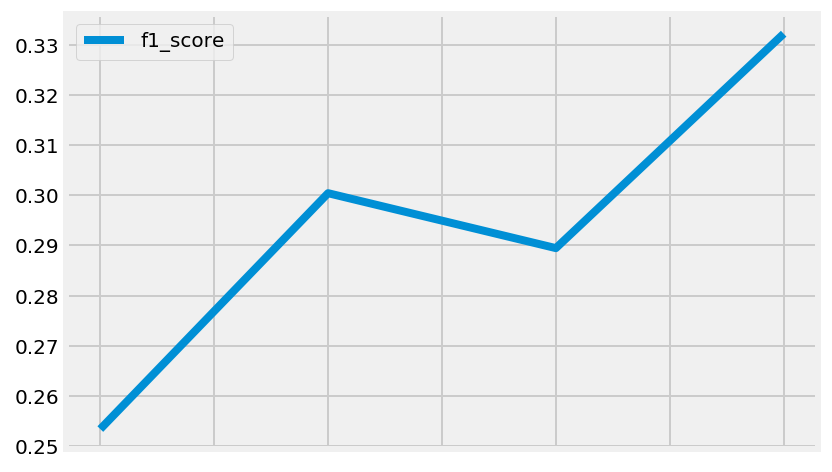

In [83]:
scores_titles.plot.line();

In [14]:
title_table = title_ass[title_ass.pobability >= 0.35]

In [15]:
body_table = body_ass[body_ass.pobability >= 0.35]

In [23]:
a = predict_tags(valid.Title[0], title_table)

In [24]:
b = predict_tags(valid.body[0], body_table)

In [27]:
a.extend(b)

In [29]:
set(a)

{'actio',
 'asp.n',
 'java',
 'mysql',
 'ruby-',
 'spring',
 'spring-mvc',
 'web-applications'}

In [16]:
a = title_table.loc[valid.Title[0].split()].dropna()

In [42]:
b = body_table.loc[valid.body[0].split()].dropna()

In [19]:
a.sort_values('pobability', ascending=False).tag.unique()

array(['spring', 'asp.net-mvc', 'java'], dtype=object)

In [51]:
pd.concat([a, b], ignore_index=True).sort_values('pobability', ascending=False).tag.unique()

array(['web-applications', 'java', 'spring-mvc', 'spring', 'asp.net-mvc',
       'actionscript-3', 'mysql', 'ruby-on-rails'], dtype=object)

In [53]:
def merge_predict(title, body, ttbl, btbl):
    ttags = None
    btags = None
    try:
        ttags = ttbl.loc[title.split()].dropna()
    except KeyError:
        pass
    try:
        btags = btbl.loc[body.split()].dropna()
    except KeyError:
        pass
    indicator = 0
    tags = ""
    if ttags is None and btags is None:
        indicator = 3
    elif ttags is None:
        indicator = 2
    elif btags is None:
        indicator = 1

    if indicator == 0:
        tags = pd.concat([ttags, btags], ignore_index=True).sort_values('pobability', 
                                                             ascending=False).tag.unique()
    elif indicator == 1:
        tags = ttags.sort_values('pobability', ascending=False).tag.unique()
    elif indicator == 2:
        tags = btags.sort_values('pobability', ascending=False).tag.unique()
    return [" ".join(tags[0:5])]

In [72]:
test_sample = valid.sample(5000)

In [73]:
from tqdm import tqdm_notebook

In [74]:
preds = []
trues = []
for title, body, tag in tqdm_notebook(zip(test_sample.Title, test_sample.body, test_sample.Tags)):    
    preds.append(merge_predict(title, body, title_table, body_table))
    trues.append([tag])

In [80]:
preds = [each[0] for each in preds]
trues = [each[0] for each in trues]

In [83]:
P = vectorizer.transform(preds)
T = vectorizer.transform(trues)

In [84]:
f1_score(T, P, average='micro')

0.4290014731313649